# Лабораторная работа 1: «Метод обратного распространения ошибки»

## Цели работы

**Цель** — изучить метод обратного распространения ошибки для обучения глубоких нейронных сетей на примере двухслойной полносвязной нейронной сети (один скрытый слой).

## Задачи работы

Выполнение работы предполагает решение следующих задач:

1. Изучение общей схемы работы метода обратного распространения ошибки с помощью стохастического градиентного спуска.
2. Вывод математических формул для вычисления градиентов функции ошибки по параметрам нейронной сети и формул коррекции весов.
3. Реализация и тестирование метода обратного распространения ошибки для классификации рукописных цифр из набора данных [MNIST](https://www.kaggle.com/datasets/hojjatk/mnist-dataset).


Конфигурация нейронной сети:

1. Входной слой содержит `w x h` нейронов, что соответствует разрешению одноканального изображения (для изображений в базе MNIST составляет 28x28).
2. Выходной слой содержит `k` нейронов, что соответствует количеству классов изображений (для задачи классификации рукописных цифр MNIST – 10 классов).
3. Скрытый слой содержит `s` нейронов (параметр).
4. Скорость обучения (learning rate), размер пачки данных (batch size), количество эпох являются параметрами метода обучения.
5. В качестве функции активации на скрытом слое используется функция ReLU. В качестве функции активации на выходном слое используется функция softmax. Входной слой не содержит функцию активации.
6. В качестве функции ошибки используется кросс-энтропия. Функция активации softmax вместе с функцией ошибки кросс-энтропия упрощают вывод формул.
7. Набор параметров для демонстрации работы нейронной сети (и выложенные материалы и демонстрации в т/к выполняется на данных параметрах):
    - Размер пачки может меняться от 8 до 64 изображений (в зависимости от доступного объема памяти).
    - Скорость обучения - 0.1.
    - Количество скрытых нейронов `s` - 300.
    - Количество эпох – 20.

## Требования к результатам выполнения работы

1. Требования к структуре и содержимому Jupyter Notebook:

   - Загрузить и проверить данные (необходимо обеспечить демонстрацию избранных изображений и меток классов для подтверждения корректности загрузки и совпадения размерностей)
   - По окончании каждой эпохи в процессе обучения модели выводится ошибка классификации на тренировочном наборе данных и время выполнения эпохи.
   - После обучения выводится ошибка классификации на тестовом наборе данных.

2. Для контрольных значений параметров достигнута точность классификации на тестовых данных, сравнимая с точностью, которую выдают стандартные инструменты глубокого обучения (например, библиотеки Keras или PyTorch). Подсказка: Точность будет ~95% с ***неправильной*** инициализации весов, ожидается результат ***лучше***.

3. Запуск необходимо выполнить в процессе очной сдачи. Время обучения на контрольном наборе параметров не должно превышать время, выделенное на сдачу работу одним студентом (~7-15 минут).

4. Реализация не должна содержать использование tensorflow, keras, pytorch или иных фреймворков глубокого обучения. Допускается использование библиотек, таких как NumPy, Matplotlib и других классических библиотек.

In [1]:
!pip install kaggle idx2numpy

  Preparing metadata (setup.py) ... done
  Created wheel for idx2numpy: filename=idx2numpy-1.2.3-py3-none-any.whl size=7904 sha256=daa2fd5950c7c9d6dc511bb61f4fbbbef4323f755939f5598dfa47242ff318be
  Stored in directory: /root/.cache/pip/wheels/e0/f4/e7/643fc5f932ec2ff92997f43f007660feb23f948aa8486f1107
Successfully built idx2numpy


In [2]:
!kaggle datasets download -d hojjatk/mnist-dataset && unzip -o -qq mnist-dataset.zip

Dataset URL: https://www.kaggle.com/datasets/hojjatk/mnist-dataset
License(s): copyright-authors
 77% 17.0M/22.0M [00:00<00:00, 93.0MB/s]
100% 22.0M/22.0M [00:00<00:00, 89.9MB/s]


In [3]:
import idx2numpy
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
%matplotlib inline

In [4]:
train_images, train_labels, test_images, test_labels = (
    idx2numpy.convert_from_file(file)
    for file in [
        "train-images.idx3-ubyte",
        "train-labels.idx1-ubyte",
        "t10k-images.idx3-ubyte",
        "t10k-labels.idx1-ubyte",
    ]
)

train_images = train_images / 255.
test_images  = test_images / 255.

print(f"Тренировочные данные:\n{train_images.shape=}; {train_labels.shape=}")
print(f"Тестовые данные:\n{test_images.shape=}; {test_labels.shape=}")

Тренировочные данные:
train_images.shape=(60000, 28, 28); train_labels.shape=(60000,)
Тестовые данные:
test_images.shape=(10000, 28, 28); test_labels.shape=(10000,)


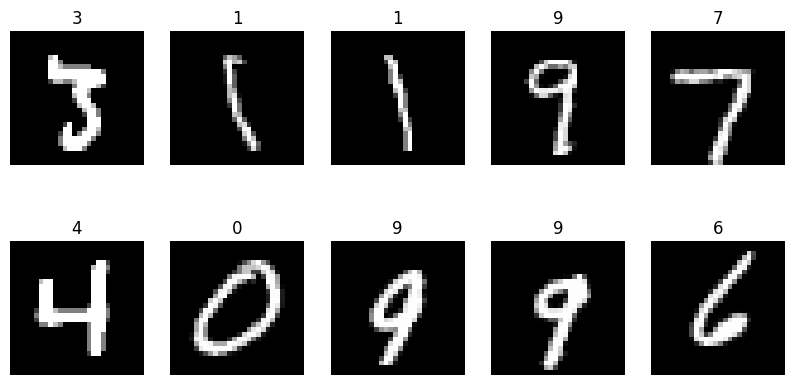

In [5]:
def plot_10_samples(samples, labels):
    fig = plt.figure(figsize=(10, 5))

    for idx, (sample, label) in enumerate(zip(samples, labels)):
        plt.subplot(2, 5, idx + 1)
        plt.imshow(sample, cmap='gray')
        plt.axis('off')
        plt.title(label)

random_indexes = np.random.randint(0, train_images.shape[0], 10)
plot_10_samples(train_images[random_indexes], train_labels[random_indexes])

In [6]:
def ReLU(x):
    return np.maximum(0, x)

def dReLU(x):
    return np.where(x > 0, 1, 0)

def softmax(x):
    exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))
    return exp_x / np.sum(exp_x, axis=1, keepdims=True)

def sparse_cross_entropy(y_true, y_pred):
    m = y_true.shape[0]
    return -np.mean(np.log(y_pred[np.arange(m), y_true]))

def cross_entropy(y_true, y_pred):
    return -np.mean(np.sum(y_true * np.log(y_pred + 1e-10), axis=1))

def accuracy(y_true, y_pred):
    return np.mean(y_pred == y_true)

def error(y_true, y_pred):
    return 1 - accuracy(y_true, y_pred)

In [7]:
def data_generator(x, y, batch_size, verbose=False, description="Batches processing"):
    total_samples = x.shape[0]
    total_batches = (total_samples - 1) // batch_size + 1

    permutation = np.random.permutation(total_samples)
    x_shuffle = x[permutation]
    y_shuffle = y[permutation]

    index_changes = np.arange(0, total_samples, batch_size)
    for i in (
        index_changes
        if not verbose
        else tqdm(index_changes, total=total_batches, desc=description)
    ):
        yield x_shuffle[i:i+batch_size], y_shuffle[i:i+batch_size]

In [8]:
class NeuralNetwork:
    def __init__(
        self,
        input_size,
        hidden_size,
        output_size,
        learning_rate,
    ) -> None:
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.learning_rate = learning_rate

        self.w1 = np.random.normal(
            loc=0,
            scale=1/input_size,
            size=(input_size, hidden_size)
        )
        self.b1 = np.zeros((1, hidden_size))

        self.w2 = np.random.normal(
            loc=0,
            scale=2/input_size,
            size=(hidden_size, output_size)
        )
        self.b2 = np.zeros((1, output_size))

    def forward(self, x):
        self.z1 = np.dot(x, self.w1) + self.b1
        self.a1 = ReLU(self.z1)

        self.z2 = np.dot(self.a1, self.w2) + self.b2
        self.a2 = softmax(self.z2)

        return self.a2

    def backward(self, x, y):
        m = x.shape[0]

        dz2 = self.a2
        dz2[np.arange(m), y] -= 1
        dz2 /= m

        dw2 = np.dot(self.a1.T, dz2)
        db2 = np.sum(dz2, axis=0, keepdims=True)

        dz1 = np.dot(dz2, self.w2.T) * dReLU(self.z1)

        dw1 = np.dot(x.T, dz1)
        db1 = np.sum(dz1, axis=0, keepdims=True)

        self.w1 -= self.learning_rate * dw1
        self.b1 -= self.learning_rate * db1
        self.w2 -= self.learning_rate * dw2
        self.b2 -= self.learning_rate * db2

    def predict_proba(self, x):
        return self.forward(x)

    def predict(self, x):
        return np.argmax(self.predict_proba(x), axis=1)

    def train(self, x_train, y_train, epochs, batch_size, verbose_batch_processing=False):
        for epoch in range(epochs):
            for x, y in data_generator(
                x_train, y_train, batch_size, verbose=verbose_batch_processing,
                description=f"Epoch {epoch + 1} - batches processing"
            ):
                self.forward(x)
                self.backward(x, y)

            y_pred = self.predict_proba(x_train)

            train_metrics = {
                "cross_entropy_loss": sparse_cross_entropy(y_train, y_pred),
                "error": error(y_train, np.argmax(y_pred, axis=1))
            }

            train_info = ', '.join([
                f"{key}: {value:.4f}"
                for key, value in train_metrics.items()
            ])
            if not verbose_batch_processing:
                print(f"Epoch {epoch + 1}: {train_info}")
            else:
                print(train_info, end='\n'*2)

In [9]:
input_size = 28 * 28
hidden_size = 300
output_size = 10

learning_rate = 0.1
batch_size = 64
epochs = 20

perceptron = NeuralNetwork(
    input_size=input_size,
    hidden_size=hidden_size,
    output_size=output_size,
    learning_rate=learning_rate,
)

perceptron.train(
    train_images.reshape(-1, input_size),
    train_labels,
    epochs=epochs,
    batch_size=batch_size,
    verbose_batch_processing=True,
)

test_error = error(
    y_true=test_labels,
    y_pred=perceptron.predict(test_images.reshape(-1, input_size)),
)
print(f"Test data: {test_error=:.4f}")

Epoch 1 - batches processing: 100%|██████████| 938/938 [00:21<00:00, 44.30it/s]


cross_entropy_loss: 0.2933, error: 0.0836



Epoch 2 - batches processing: 100%|██████████| 938/938 [00:13<00:00, 70.84it/s] 


cross_entropy_loss: 0.2160, error: 0.0623



Epoch 3 - batches processing: 100%|██████████| 938/938 [00:08<00:00, 107.15it/s]


cross_entropy_loss: 0.1617, error: 0.0460



Epoch 4 - batches processing: 100%|██████████| 938/938 [00:06<00:00, 145.18it/s]


cross_entropy_loss: 0.1329, error: 0.0374



Epoch 5 - batches processing: 100%|██████████| 938/938 [00:03<00:00, 241.64it/s]


cross_entropy_loss: 0.1049, error: 0.0295



Epoch 6 - batches processing: 100%|██████████| 938/938 [00:05<00:00, 165.43it/s]


cross_entropy_loss: 0.0906, error: 0.0250



Epoch 7 - batches processing: 100%|██████████| 938/938 [00:03<00:00, 246.13it/s]


cross_entropy_loss: 0.0768, error: 0.0209



Epoch 8 - batches processing: 100%|██████████| 938/938 [00:04<00:00, 192.05it/s]


cross_entropy_loss: 0.0683, error: 0.0189



Epoch 9 - batches processing: 100%|██████████| 938/938 [00:03<00:00, 245.67it/s]


cross_entropy_loss: 0.0592, error: 0.0160



Epoch 10 - batches processing: 100%|██████████| 938/938 [00:03<00:00, 247.28it/s]


cross_entropy_loss: 0.0553, error: 0.0152



Epoch 11 - batches processing: 100%|██████████| 938/938 [00:05<00:00, 174.10it/s]


cross_entropy_loss: 0.0494, error: 0.0131



Epoch 12 - batches processing: 100%|██████████| 938/938 [00:03<00:00, 246.66it/s]


cross_entropy_loss: 0.0430, error: 0.0110



Epoch 13 - batches processing: 100%|██████████| 938/938 [00:05<00:00, 161.65it/s]


cross_entropy_loss: 0.0396, error: 0.0104



Epoch 14 - batches processing: 100%|██████████| 938/938 [00:03<00:00, 238.69it/s]


cross_entropy_loss: 0.0348, error: 0.0081



Epoch 15 - batches processing: 100%|██████████| 938/938 [00:05<00:00, 163.78it/s]


cross_entropy_loss: 0.0343, error: 0.0084



Epoch 16 - batches processing: 100%|██████████| 938/938 [00:04<00:00, 203.42it/s]


cross_entropy_loss: 0.0326, error: 0.0081



Epoch 17 - batches processing: 100%|██████████| 938/938 [00:04<00:00, 188.84it/s]


cross_entropy_loss: 0.0266, error: 0.0054



Epoch 18 - batches processing: 100%|██████████| 938/938 [00:03<00:00, 245.93it/s]


cross_entropy_loss: 0.0253, error: 0.0054



Epoch 19 - batches processing: 100%|██████████| 938/938 [00:03<00:00, 242.45it/s]


cross_entropy_loss: 0.0228, error: 0.0045



Epoch 20 - batches processing: 100%|██████████| 938/938 [00:05<00:00, 179.07it/s]


cross_entropy_loss: 0.0208, error: 0.0039

Test data: test_error=0.0192
